<a href="https://colab.research.google.com/github/Colecgame/Colecgame/blob/main/Desafio_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = '/content/drive/MyDrive/data.csv'

df = pd.read_csv(file_path, encoding='ISO-8859-1')

In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [ ]:
# Converter InvoiceDate para tipo datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [ ]:
# Conferência da conversão
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
# Verificar estrutura básica
print("Formato do DataFrame:", df.shape)
print("\nTipos de dados:")
print(df.dtypes)

Formato do DataFrame: (541909, 8)

Tipos de dados:
InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object


O DataFrame possui 541.909 registros e 8 colunas. As colunas InvoiceNo, StockCode, Description, CustomerID e Country são categóricas. A coluna InvoiceDate foi corretamente convertida para o tipo datetime, o que é essencial para o cálculo da Recência na próxima etapa. CustomerID necessita conversão.

In [ ]:
# Descrição estatística geral das colunas numéricas
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


Quantity: Apresenta valores negativos, indicando devoluções ou cancelamentos de compra.

UnitPrice: Também possui valores negativos, o que não é válido — esses registros serão removidos.

CustomerID: Está ausente em cerca de 25% das linhas. Esses registros serão descartados pois não permitem análise de comportamento individual.

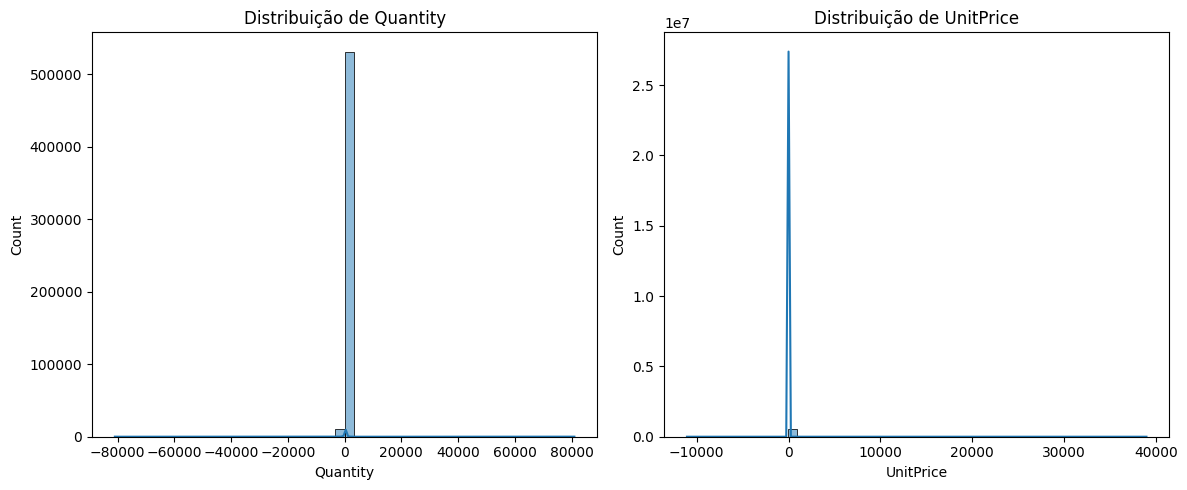

In [ ]:
# Lista de colunas numéricas
num_cols = ['Quantity', 'UnitPrice']

# Criar histogramas
plt.figure(figsize=(12, 5))
for i, col in enumerate(num_cols):
    plt.subplot(1, 2, i + 1)
    sns.histplot(df[col], bins=50, kde=True)
    plt.title(f'Distribuição de {col}')
plt.tight_layout()
plt.show()


Os histogramas mostraram distribuições altamente assimétricas (cauda longa), com concentração de valores baixos e presença de outliers extremos nas variáveis Quantity e UnitPrice. A limpeza desses valores é necessária para evitar distorções nos agrupamentos futuros.

In [ ]:
# Exibir os produtos mais comuns
print("Top 5 produtos mais vendidos:")
print(df['Description'].value_counts().head())

# Exibir os países com mais transações
print("\nTop 5 países com mais transações:")
print(df['Country'].value_counts().head())

Top 5 produtos mais vendidos:
Description
WHITE HANGING HEART T-LIGHT HOLDER    2369
REGENCY CAKESTAND 3 TIER              2200
JUMBO BAG RED RETROSPOT               2159
PARTY BUNTING                         1727
LUNCH BAG RED RETROSPOT               1638
Name: count, dtype: int64

Top 5 países com mais transações:
Country
United Kingdom    495478
Germany             9495
France              8557
EIRE                8196
Spain               2533
Name: count, dtype: int64


O produto mais vendido é o WHITE HANGING HEART T-LIGHT HOLDER.

Mais de 90% das transações vêm do Reino Unido, o que mostra a dominância desse mercado na base e pode influenciar nas decisões de segmentação.

Valores nulos por coluna:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Total de registros duplicados:
5268


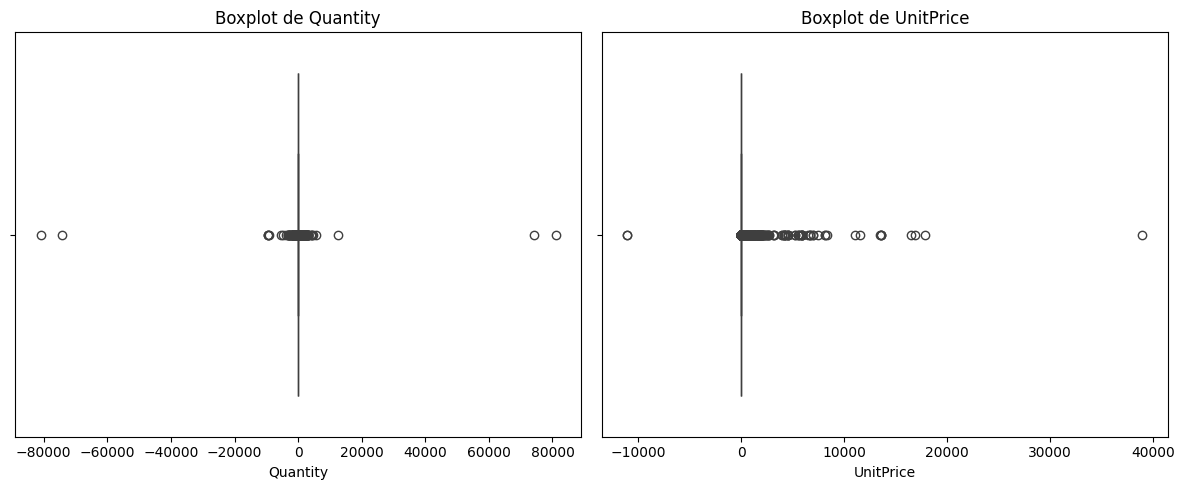

In [ ]:
# Verificar valores nulos
print("Valores nulos por coluna:")
print(df.isnull().sum())

# Verificar duplicatas
print("\nTotal de registros duplicados:")
print(df.duplicated().sum())

# Visualização de outliers com boxplot
plt.figure(figsize=(12, 5))
for i, col in enumerate(['Quantity', 'UnitPrice']):
    plt.subplot(1, 2, i + 1)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot de {col}')
plt.tight_layout()
plt.show()

CustomerID tem 135.080 valores nulos — registros sem cliente identificado.

Description tem 1.454 nulos, talvez associados a devoluções.

Foram encontrados 5.268 registros duplicados, que deverão ser removidos.

Os boxplots reforçaram a presença de outliers negativos e positivos extremos nas variáveis Quantity e UnitPrice.

In [ ]:
# Remover registros com CustomerID nulo
df_clean = df.dropna(subset=['CustomerID'])

# Remover duplicatas
df_clean = df_clean.drop_duplicates()

# Remover registros com Quantity <= 0 ou UnitPrice <= 0
df_clean = df_clean[(df_clean['Quantity'] > 0) & (df_clean['UnitPrice'] > 0)]

# Resetar index
df_clean = df_clean.reset_index(drop=True)

# Converter CustomerID para categórico
df_clean['CustomerID'] = df_clean['CustomerID'].astype('category')

In [ ]:
print("Formato após limpeza:", df_clean.shape)
print("CustomerID únicos:", df_clean['CustomerID'].nunique())

Formato após limpeza: (392692, 8)
CustomerID únicos: 4338


In [ ]:
# Verificar valores nulos (df limpo)
print("Valores nulos por coluna:")
print(df_clean.isnull().sum())

# Verificar duplicatas (df limpo)
print("\nTotal de registros duplicados:")
print(df_clean.duplicated().sum())

Valores nulos por coluna:
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

Total de registros duplicados:
0


In [ ]:
import datetime as dt

# Data de referência: um dia após a última compra no dataset
data_ref = df_clean['InvoiceDate'].max() + dt.timedelta(days=1)

# Agrupar por cliente
rfv = df_clean.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (data_ref - x.max()).days,   # Recência
    'InvoiceNo': 'nunique',                               # Frequência
    'UnitPrice': 'sum'                                    # Valor
}).reset_index()

# Renomear colunas
rfv.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

/tmp/ipython-input-4163781137.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rfv = df_clean.groupby('CustomerID').agg({


In [ ]:
# Normalizar as variáveis
scaler = StandardScaler()
rfv_scaled = scaler.fit_transform(rfv[['Recency', 'Frequency', 'Monetary']])

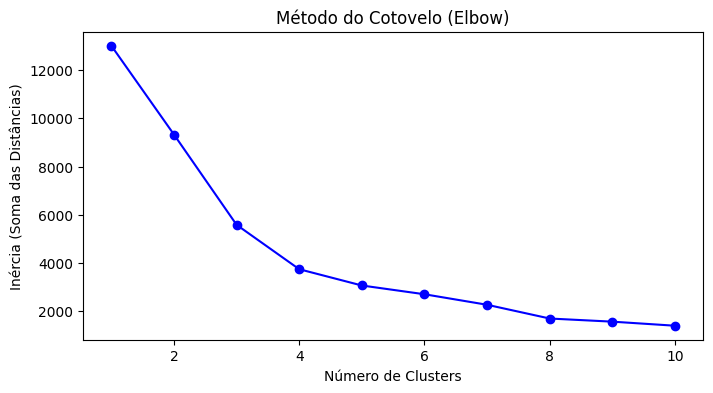

In [ ]:
# Elbow
inertia = []
range_n = range(1, 11)

for k in range_n:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfv_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(range_n, inertia, 'bo-')
plt.xlabel('Número de Clusters')
plt.ylabel('Inércia (Soma das Distâncias)')
plt.title('Método do Cotovelo (Elbow)')
plt.show()


In [ ]:
# Silhouette Score
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfv_scaled)
    score = silhouette_score(rfv_scaled, kmeans.labels_)
    print(f'k={k} => Silhouette Score: {score:.4f}')

k=2 => Silhouette Score: 0.5435
k=3 => Silhouette Score: 0.5632
k=4 => Silhouette Score: 0.5989
k=5 => Silhouette Score: 0.5601
k=6 => Silhouette Score: 0.5208
k=7 => Silhouette Score: 0.4670
k=8 => Silhouette Score: 0.4875
k=9 => Silhouette Score: 0.4873
k=10 => Silhouette Score: 0.3899


In [ ]:
# Os dois métodos apontam para a mesma quantidade ideal de clusters, 4
kmeans = KMeans(n_clusters=4, random_state=42)
rfv['Cluster'] = kmeans.fit_predict(rfv_scaled)

In [ ]:
cluster_summary = rfv.groupby('Cluster').agg({
    'Recency': ['mean', 'median'],
    'Frequency': ['mean', 'median'],
    'Monetary': ['mean', 'median'],
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'TotalClientes'})

In [ ]:
cluster_summary

Recency          Frequency             Monetary             \
               mean median        mean median          mean     median   
Cluster                                                                  
0         43.883041   32.0    3.742365    3.0    236.478240    151.985   
1        249.025472  243.0    1.543396    1.0     94.783897     62.445   
2          2.000000    1.5  137.750000  162.5  22685.697500  22811.015   
3         12.122449    5.0   24.622449   20.0   1573.610408   1197.175   

        TotalClientes  
                count  
Cluster                
0                3078  
1                1060  
2                   4  
3                 196

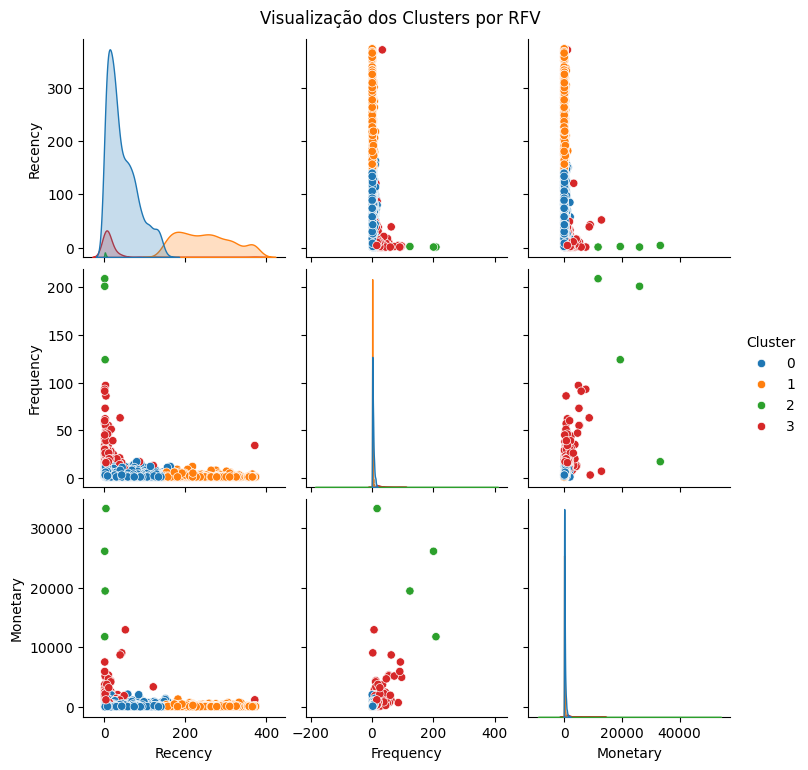

In [ ]:
# Plotagem em par plot
sns.pairplot(rfv, hue='Cluster', vars=['Recency', 'Frequency', 'Monetary'], palette='tab10')
plt.suptitle('Visualização dos Clusters por RFV', y=1.02)
plt.show()


### 🎯 Perfis de Clientes por Cluster

#### 🔵 **Cluster 0 – Clientes Regulares**

* **Recência**: \~44 dias
* **Frequência**: \~3,7 compras
* **Valor Monetário**: \~£236
* **Total de Clientes**: **3.078**

**Perfil:**
São clientes que compraram recentemente, com frequência e valores moderados. Representam a maior parte da base.

**Ação sugerida:**
Campanhas de retenção, e-mails com recomendações de produtos e programas de fidelidade podem manter esse grupo ativo e engajado.

---

#### 🟠 **Cluster 1 – Clientes Inativos ou Desengajados**

* **Recência**: \~249 dias
* **Frequência**: \~1,5 compras
* **Valor Monetário**: \~£95
* **Total de Clientes**: **1.060**

**Perfil:**
Clientes que compraram há muito tempo, com baixa frequência e pouco gasto. Estão inativos ou prestes a se tornarem.

**Ação sugerida:**
Campanhas de reativação com cupons de desconto, ofertas de frete grátis ou recomendações baseadas em histórico anterior.

---

#### 🟢 **Cluster 2 – Clientes Premium**

* **Recência**: 2 dias
* **Frequência**: \~138 compras
* **Valor Monetário**: \~£22.685
* **Total de Clientes**: **4**

**Perfil:**
Clientes extremamente fiéis, de altíssimo valor, que compram com muita frequência e recentemente. Representam alto valor mesmo em baixa quantidade.

**Ação sugerida:**
Oferecer vantagens exclusivas como atendimento VIP, programas de recompensa premium, brindes personalizados ou acesso antecipado a lançamentos.

---

#### 🔴 **Cluster 3 – Clientes de Alto Potencial**

* **Recência**: \~12 dias
* **Frequência**: \~24,6 compras
* **Valor Monetário**: \~£1.574
* **Total de Clientes**: **196**

**Perfil:**
Clientes ativos, comprando com frequência e com um valor considerável. Apresentam potencial para evoluírem ao perfil premium.

**Ação sugerida:**
Campanhas de upsell e cross-sell, programas de fidelidade mais agressivos ou recomendações personalizadas para maximizar o LTV (valor vitalício do cliente).

---

### 📊 Justificativa da Análise

A análise de clusterização utilizando RFV (Recência, Frequência e Valor Monetário) permitiu segmentar os clientes com base em **comportamentos reais de compra**, revelando **padrões claros** e **oportunidades estratégicas**. Essa abordagem permite:

* **Personalizar campanhas de marketing** conforme o perfil do cliente;
* **Aumentar a retenção** dos melhores clientes;
* **Reativar clientes inativos** com ações focadas;
* **Maximizar ROI** ao investir os recursos de forma inteligente e segmentada;
* **Identificar potenciais clientes VIP** para ações especiais.

---

### 💡 Sugestões de Ações por Cluster

| Cluster                        | Estratégia                                                                                                                  |
| ------------------------------ | --------------------------------------------------------------------------------------------------------------------------- |
| **Cluster 0 – Regulares**      | Manter engajamento com promoções periódicas, recomendação de produtos e programa de pontos.                                 |
| **Cluster 1 – Inativos**       | Reengajar com e-mails personalizados, ofertas de “volte a comprar”, cupons de boas-vindas ou campanhas nostálgicas.         |
| **Cluster 2 – Premium**        | Fidelização com atendimento VIP, acesso exclusivo, brindes, convites para eventos e acompanhamento pós-venda.               |
| **Cluster 3 – Alto Potencial** | Incentivar mais compras com campanhas de upgrade (ex: “compre mais e ganhe”), produtos relacionados ou combos promocionais. |
